**Experiment 1**

In [1]:
#Cell 1 — Install dependencies
!pip -q install opacus==1.4.0 tqdm pandas matplotlib torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 21.0 MB/s eta 0:00:00


In [2]:
#Cell 2 — Imports + reproducibility
import os, math, random, re, subprocess
from copy import deepcopy
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

from opacus.accountants import RDPAccountant

# Wider alpha grid => avoids "optimal order is the largest alpha" warning
RDP_ALPHAS = (
    [1.01, 1.05] +
    [1.1 + 0.1*i for i in range(0, 90)] +      # 1.1..10.0
    list(range(11, 64)) + [64, 128, 256, 512]
)

def seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [3]:
#Cell 3 — Download Fashion‑MNIST
#torchvision downloads it automatically.
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

train_ds = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
test_ds = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

test_loader = DataLoader(test_ds, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)
print(len(train_ds), len(test_ds))

100%|██████████| 26.4M/26.4M [00:11<00:00, 2.37MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 178kB/s]
100%|██████████| 4.42M/4.42M [00:06<00:00, 699kB/s] 
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.8MB/s]

60000 10000


In [4]:
#Cell 4 — Make 6000 clients × 10 samples/client (FedVRDP-style)
def make_cross_device_clients(train_dataset, num_clients=6000, samples_per_client=10, seed=0):
    assert num_clients * samples_per_client <= len(train_dataset)
    rng = np.random.default_rng(seed)
    idx = rng.permutation(len(train_dataset)).tolist()
    clients = []
    for c in range(num_clients):
        clients.append(idx[c*samples_per_client:(c+1)*samples_per_client])
    return clients

clients = make_cross_device_clients(train_ds, num_clients=6000, samples_per_client=10, seed=0)
print("num clients:", len(clients), "samples/client:", len(clients[0]))

num clients: 6000 samples/client: 10


In [5]:
#Cell 5 — Optional “public anchor set” (2 samples/class)
#This mirrors the idea “tiny auxiliary data is easy to obtain” used by Xiang et al
#If we want to skip this, set public_idx = [] and don’t filter.
def extract_public_per_class(dataset, per_class=2, seed=0):
    rng = np.random.default_rng(seed)
    targets = np.array(dataset.targets)
    public_idx = []
    for k in range(10):
        cls_idx = np.where(targets == k)[0]
        rng.shuffle(cls_idx)
        public_idx.extend(cls_idx[:per_class].tolist())
    public_idx = sorted(public_idx)
    return public_idx

public_idx = extract_public_per_class(train_ds, per_class=2, seed=0)
public_loader = DataLoader(Subset(train_ds, public_idx), batch_size=20, shuffle=False)

# Remove public samples from clients so they are not used privately
public_set = set(public_idx)
clients_wo_public = []
for cid in range(len(clients)):
    filtered = [i for i in clients[cid] if i not in public_set]
    clients_wo_public.append(filtered)

clients = clients_wo_public
print("public samples:", len(public_idx), "| example client size after removal:", len(clients[0]))

public samples: 20 | example client size after removal: 10


In [6]:
#Cell 6 — Model (CNN like FedVRDP description)
#FedVRDP describes a CNN with 2 conv layers, maxpool, ReLU, FC(512).
class FMNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=0)
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))       # 28->24
        x = F.max_pool2d(x, 2)          # 24->12
        x = F.relu(self.conv2(x))       # 12->8
        x = F.max_pool2d(x, 2)          # 8->4
        x = x.view(x.size(0), -1)       # 64*4*4
        x = F.relu(self.fc1(x))
        return self.fc2(x)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / total

In [7]:
#Cell 7 — Tensor-list utilities (fast, no giant flatten)
def model_param_list(model):
    return [p for p in model.parameters() if p.requires_grad]

@torch.no_grad()
def zero_like_params(model):
    return [torch.zeros_like(p) for p in model_param_list(model)]

@torch.no_grad()
def add_update_(model, update_list, scale=1.0):
    for p, u in zip(model_param_list(model), update_list):
        p.data.add_(u, alpha=scale)

@torch.no_grad()
def l2_norm_list(tlist):
    s = None
    for t in tlist:
        v = (t*t).sum()
        s = v if s is None else s + v
    return torch.sqrt(s + 1e-12)

@torch.no_grad()
def dot_list(a_list, b_list):
    s = None
    for a, b in zip(a_list, b_list):
        v = (a*b).sum()
        s = v if s is None else s + v
    return s

@torch.no_grad()
def add_scaled_list_(dst, src, alpha):
    for d, s in zip(dst, src):
        d.add_(s, alpha=alpha)

@torch.no_grad()
def sub_list(a, b):
    return [x - y for x, y in zip(a, b)]

In [8]:
#Cell 8 — Local client training (returns update = local_model − global_model)
def client_update(global_model, client_indices, lr, momentum, local_epochs, batch_size=10):
    local_model = deepcopy(global_model)
    local_model.train()

    loader = DataLoader(Subset(train_ds, client_indices),
                        batch_size=batch_size, shuffle=True, drop_last=False)

    opt = torch.optim.SGD(local_model.parameters(), lr=lr, momentum=momentum)
    loss_fn = nn.CrossEntropyLoss()

    for _ in range(local_epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(local_model(x), y)
            loss.backward()
            opt.step()

    # delta = local - global
    delta = []
    for lp, gp in zip(model_param_list(local_model), model_param_list(global_model)):
        delta.append((lp.data - gp.data).detach())
    return delta

In [9]:
#Cell 9 — DP accounting helpers (compute noise multiplier for target ε)
#We will use RDP accountant_toggle: sample rate  𝑞=clients per round/total clients, steps = rounds.

# Cell 9 — DP accounting helpers (Opacus 1.4.0 compatible)

from opacus.accountants import RDPAccountant

def epsilon_from_sigma_dp_sgd(sigma, q, steps, delta):
    acc = RDPAccountant()  # <-- no alphas here
    for _ in range(steps):
        acc.step(noise_multiplier=sigma, sample_rate=q)
    return acc.get_epsilon(delta)

def epsilon_from_sigma_two_mech(sigma_sel, sigma_rel, q, steps, delta):
    acc = RDPAccountant()  # <-- no alphas here
    for _ in range(steps):
        acc.step(noise_multiplier=sigma_sel, sample_rate=q)  # selection
        acc.step(noise_multiplier=sigma_rel, sample_rate=q)  # release
    return acc.get_epsilon(delta)

def find_sigma_for_target_eps_single(target_eps, q, steps, delta, lo=0.1, hi=80.0, iters=40):
    for _ in range(iters):
        mid = (lo + hi) / 2
        eps = epsilon_from_sigma_dp_sgd(mid, q, steps, delta)
        if eps > target_eps:
            lo = mid
        else:
            hi = mid
    return hi

def find_sigma_for_target_eps_two(target_eps, q, steps, delta, sel_factor=4.0, lo=0.1, hi=200.0, iters=40):
    for _ in range(iters):
        mid = (lo + hi) / 2
        eps = epsilon_from_sigma_two_mech(sel_factor*mid, mid, q, steps, delta)
        if eps > target_eps:
            lo = mid
        else:
            hi = mid
    return hi

def report_noise_scales(target_eps, q, rounds, delta, C, M, rho, tau, sel_factor):
    nm_fedavg = find_sigma_for_target_eps_single(target_eps, q, rounds, delta)
    nm_rel    = find_sigma_for_target_eps_two(target_eps, q, rounds, delta, sel_factor=sel_factor)
    nm_sel    = sel_factor * nm_rel

    noise_mean = nm_fedavg * (C / M)     # DP-FedAvg released mean noise std
    noise_rel  = nm_rel * (rho / tau)    # AG-PTR released update noise std (conservative, denom>=tau)

    achieved = epsilon_from_sigma_two_mech(nm_sel, nm_rel, q, rounds, delta)

    print(f"Target eps_total = {target_eps}")
    print(f"q={q:.4f}, rounds={rounds}, delta={delta}")
    print(f"[DP-FedAvg] nm={nm_fedavg:.4f}  -> noise_std_on_mean = {noise_mean:.6g} (C/M)")
    print(f"[AG-PTR]   nm_sel={nm_sel:.4f}")
    print(f"[AG-PTR]   nm_rel={nm_rel:.4f} -> noise_std_on_release ≈ {noise_rel:.6g} (rho/tau)")
    print(f"[AG-PTR] achieved eps ≈ {achieved:.3f} (target {target_eps})")
    print(f"Noise ratio (AG-PTR / FedAvg) = {noise_rel/(noise_mean+1e-12):.3f}")




In [10]:
#Cell 10 — DP‑FedAvg training loop
def train_dp_fedavg(seed, eps_total, delta=1e-5,
                    num_clients=6000, clients_per_round=100,
                    rounds=180, local_epochs=10, batch_size=10,
                    lr0=0.125, lr_decay=0.99, momentum=0.5,
                    clip_C=1.0):

    seed_all(seed)
    model = FMNIST_CNN().to(device)
    q = clients_per_round / num_clients

    sigma = find_sigma_for_target_eps_single(eps_total, q, rounds, delta)
    achieved_eps = epsilon_from_sigma_dp_sgd(sigma, q, rounds, delta)

    mean_noise_std = sigma * (clip_C / clients_per_round)
    print(f"[DP-FedAvg] target eps={eps_total} -> nm={sigma:.4f}, achieved eps≈{achieved_eps:.3f}, mean-noise-std≈{mean_noise_std:.6g}")

    for t in tqdm(range(rounds), desc=f"DP-FedAvg eps={eps_total}"):
        lr_t = lr0 * (lr_decay ** t)
        chosen = np.random.choice(num_clients, size=clients_per_round, replace=False)

        sum_update = zero_like_params(model)

        for cid in chosen:
            delta_i = client_update(model, clients[cid], lr=lr_t, momentum=momentum,
                                    local_epochs=local_epochs, batch_size=batch_size)

            norm = l2_norm_list(delta_i)
            scale = min(1.0, clip_C / (norm.item() + 1e-12))
            add_scaled_list_(sum_update, delta_i, scale)

        # add Gaussian noise to the SUM (std = sigma * C)
        for j in range(len(sum_update)):
            sum_update[j].add_(torch.randn_like(sum_update[j]) * (sigma * clip_C))

        avg_update = [u / clients_per_round for u in sum_update]
        add_update_(model, avg_update, scale=1.0)

    acc = evaluate(model, test_loader)
    return acc, achieved_eps, sigma


In [11]:
#Cell 11 — Compute a per-round anchor from the small public dataset

from collections import deque
import numpy as np
import math

@torch.no_grad()
def clone_list(tlist):
    return [t.detach().clone() for t in tlist]

@torch.no_grad()
def norm_sq_list(tlist):
    s = None
    for t in tlist:
        v = (t*t).sum()
        s = v if s is None else s + v
    return float(s.item())

def train_ag_ptr(seed, eps_total, delta=1e-5,
                 num_clients=6000, clients_per_round=100,
                 rounds=180, local_epochs=10, batch_size=10,
                 lr0=0.125, lr_decay=0.99, momentum=0.5,
                 R=8,
                 rho=0.85, tau=90,
                 sel_factor=4.0,
                 anchor_mode="public_plus_zero",  # <-- NEW
                 public_indices=None,            # <-- pass public_idx here
                 public_epochs=1,                # compute public anchor with 1 epoch
                 public_batch_size=20,
                 debug_anchors=False,
                 log_every=0):

    seed_all(seed)
    model = FMNIST_CNN().to(device)
    q = clients_per_round / num_clients

    sigma_rel = find_sigma_for_target_eps_two(eps_total, q, rounds, delta, sel_factor=sel_factor)
    sigma_sel = sel_factor * sigma_rel
    achieved_eps = epsilon_from_sigma_two_mech(sigma_sel, sigma_rel, q, rounds, delta)
    print(f"[AG-PTR] eps={eps_total} -> nm_rel={sigma_rel:.4f}, nm_sel={sigma_sel:.4f}, achieved eps≈{achieved_eps:.3f}")

    zero_anchor = zero_like_params(model)

    # optional: history (kept for later experiments; not used in public_plus_zero)
    hist = deque(maxlen=max(0, R-1))

    accept = 0
    total_contrib = 0
    total_clipped = 0
    total_used = 0

    winner_all = np.zeros(R, dtype=int)
    winner_acc = np.zeros(R, dtype=int)

    # helper: build anchor set for the round
    def build_anchors(lr_t):
        if anchor_mode == "history_zero":
            anchors = [zero_anchor] + list(hist)
            while len(anchors) < R:
                anchors.append(zero_anchor)
            zero_index = 0
            return anchors, zero_index

        if anchor_mode == "public_plus_zero":
            assert public_indices is not None and len(public_indices) > 0, "Pass public_idx into public_indices"

            # public anchor = update computed on public samples
            a_pub = client_update(model, public_indices,
                                  lr=lr_t, momentum=momentum,
                                  local_epochs=public_epochs,
                                  batch_size=public_batch_size)

            # Make (R-1) duplicates of public anchor so everyone piles into the same bin if it is closer than zero.
            # Put zero as LAST anchor as a fallback.
            anchors = [a_pub for _ in range(R-1)] + [zero_anchor]
            zero_index = R - 1
            return anchors, zero_index

        raise ValueError(f"Unknown anchor_mode: {anchor_mode}")

    for t in tqdm(range(rounds), desc=f"AG-PTR eps={eps_total}"):
        lr_t = lr0 * (lr_decay ** t)
        chosen = np.random.choice(num_clients, size=clients_per_round, replace=False)

        anchors, zero_index = build_anchors(lr_t)
        anchor_norms = [norm_sq_list(a) for a in anchors]

        # cache client updates
        deltas = []
        delta_norms = []
        for cid in chosen:
            d = client_update(model, clients[cid], lr=lr_t, momentum=momentum,
                              local_epochs=local_epochs, batch_size=batch_size)
            deltas.append(d)
            delta_norms.append(norm_sq_list(d))

        # Phase 1: nearest-anchor assignment
        counts = np.zeros(R, dtype=np.float64)
        assigns = []

        for d, dn in zip(deltas, delta_norms):
            best_r = 0
            best_dist2 = float("inf")
            for r in range(R):
                dist2 = dn + anchor_norms[r] - 2.0 * float(dot_list(d, anchors[r]).item())
                if dist2 < best_dist2:
                    best_dist2 = dist2
                    best_r = r
            assigns.append(best_r)
            counts[best_r] += 1.0

        noisy_counts = counts + np.random.normal(0.0, sigma_sel, size=R)
        r_star = int(np.argmax(noisy_counts))
        winner_noisy = float(noisy_counts[r_star])

        winner_all[r_star] += 1

        # gate
        if winner_noisy < tau:
            continue

        accept += 1
        winner_acc[r_star] += 1

        # Phase 2: release
        a_star = anchors[r_star]
        sum_offsets = zero_like_params(model)

        contrib = 0
        clipped = 0
        for d, r_i in zip(deltas, assigns):
            if r_i != r_star:
                continue
            contrib += 1
            offset = sub_list(d, a_star)
            off_norm = l2_norm_list(offset).item()
            scale = min(1.0, rho / (off_norm + 1e-12))
            if scale < 1.0:
                clipped += 1
            add_scaled_list_(sum_offsets, offset, scale)

        total_contrib += contrib
        total_clipped += clipped
        total_used += max(1, contrib)

        m_hat = max(float(tau), winner_noisy)

        # noise to SUM offsets
        for j in range(len(sum_offsets)):
            sum_offsets[j].add_(torch.randn_like(sum_offsets[j]) * (sigma_rel * rho))

        u_t = [a + (so / m_hat) for a, so in zip(a_star, sum_offsets)]
        add_update_(model, u_t, scale=1.0)

        # keep history for later experiments if you want
        if R > 1:
            hist.appendleft(clone_list(u_t))

        if log_every and ((t + 1) % log_every == 0):
            ar = accept / (t + 1)
            avg_c = total_contrib / max(1, accept)
            clip_rate = total_clipped / max(1, total_used)
            print(f"  [t={t+1}] accept={ar:.3f}, avg_contrib={avg_c:.1f}, clip_rate={clip_rate:.3f}")

    acc = evaluate(model, test_loader)
    accept_rate = accept / rounds
    avg_contrib = total_contrib / max(1, accept)
    clip_rate = total_clipped / max(1, total_used)

    if debug_anchors:
        print("\n[AG-PTR debug] Winner histogram (all rounds):", winner_all, "sum=", winner_all.sum())
        print("[AG-PTR debug] Winner histogram (accepted rounds):", winner_acc, "sum=", winner_acc.sum())
        z_all = winner_all[zero_index] / max(1, winner_all.sum())
        z_acc = winner_acc[zero_index] / max(1, winner_acc.sum())
        print(f"[AG-PTR debug] ZERO-FALLBACK winner fraction: all={z_all:.3f}, accepted={z_acc:.3f}")

    return acc, achieved_eps, (sigma_sel, sigma_rel), accept_rate, avg_contrib, clip_rate


In [12]:
#NEW pilot cell (ε=1 and ε=4) that sweeps τ (and sets ρ automatically)
NUM_CLIENTS = 6000
M = 100
ROUNDS_PILOT = 30
LOCAL_EPOCHS_PILOT = 2
DELTA = 1e-5

CLIP_C = 1.0
R = 8
SEL_FACTOR = 4.0
SEED = 1
EPS_LIST = [1, 4]

TAU_GRID = [90, 80, 70, 60]   # include 90 just to see the drop
RATIO_TARGET = 0.9            # keep (rho/tau)/(C/M) = 0.9

def rho_from_tau(tau, C=1.0, M=100, ratio=0.9):
    return ratio * (C/M) * tau  # rho = ratio * (C/M) * tau

for EPS in EPS_LIST:
    print("\n==============================")
    print("PILOT EPS =", EPS)

    acc_fa, _, _ = train_dp_fedavg(
        SEED, EPS, delta=DELTA,
        num_clients=NUM_CLIENTS, clients_per_round=M,
        rounds=ROUNDS_PILOT, local_epochs=LOCAL_EPOCHS_PILOT, batch_size=10,
        lr0=0.125, lr_decay=0.99, momentum=0.5,
        clip_C=CLIP_C
    )
    print("Pilot DP-FedAvg acc:", acc_fa)

    for TAU in TAU_GRID:
        RHO = rho_from_tau(TAU, C=CLIP_C, M=M, ratio=RATIO_TARGET)
        ratio = (RHO/TAU) / (CLIP_C/M)

        acc_ag, _, _, ar, avg_contrib, clip_rate = train_ag_ptr(
            SEED, EPS, delta=DELTA,
            num_clients=NUM_CLIENTS, clients_per_round=M,
            rounds=ROUNDS_PILOT, local_epochs=LOCAL_EPOCHS_PILOT, batch_size=10,
            lr0=0.125, lr_decay=0.99, momentum=0.5,
            R=R, rho=RHO, tau=TAU, sel_factor=SEL_FACTOR,
            anchor_mode="public_plus_zero",
            public_indices=public_idx,
            public_epochs=1,
            public_batch_size=len(public_idx),
            debug_anchors=True,
            log_every=0
        )

        print(f"  tau={TAU:>2} rho={RHO:.3f} | acc={acc_ag:.4f} accept={ar:.3f} contrib={avg_contrib:.1f} clip={clip_rate:.3f} | ratio={ratio:.3f}")



PILOT EPS = 1


/usr/local/lib/python3.12/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


[DP-FedAvg] target eps=1 -> nm=1.1314, achieved eps≈1.000, mean-noise-std≈0.0113135


DP-FedAvg eps=1: 100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


Pilot DP-FedAvg acc: 0.7347
[AG-PTR] eps=1 -> nm_rel=1.1323, nm_sel=4.5293, achieved eps≈1.000


AG-PTR eps=1: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s]



[AG-PTR debug] Winner histogram (all rounds): [28  0  0  0  0  0  0  2] sum= 30
[AG-PTR debug] Winner histogram (accepted rounds): [4 0 0 0 0 0 0 0] sum= 4
[AG-PTR debug] ZERO-FALLBACK winner fraction: all=0.067, accepted=0.000
  tau=90 rho=0.810 | acc=0.4645 accept=0.133 contrib=93.0 clip=0.121 | ratio=0.900
[AG-PTR] eps=1 -> nm_rel=1.1323, nm_sel=4.5293, achieved eps≈1.000


AG-PTR eps=1: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s]



[AG-PTR debug] Winner histogram (all rounds): [30  0  0  0  0  0  0  0] sum= 30
[AG-PTR debug] Winner histogram (accepted rounds): [7 0 0 0 0 0 0 0] sum= 7
[AG-PTR debug] ZERO-FALLBACK winner fraction: all=0.000, accepted=0.000
  tau=80 rho=0.720 | acc=0.4621 accept=0.233 contrib=86.1 clip=0.317 | ratio=0.900
[AG-PTR] eps=1 -> nm_rel=1.1323, nm_sel=4.5293, achieved eps≈1.000


AG-PTR eps=1: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]



[AG-PTR debug] Winner histogram (all rounds): [17  0  0  0  0  0  0 13] sum= 30
[AG-PTR debug] Winner histogram (accepted rounds): [8 0 0 0 0 0 0 3] sum= 11
[AG-PTR debug] ZERO-FALLBACK winner fraction: all=0.433, accepted=0.273
  tau=70 rho=0.630 | acc=0.5902 accept=0.367 contrib=79.3 clip=0.672 | ratio=0.900
[AG-PTR] eps=1 -> nm_rel=1.1323, nm_sel=4.5293, achieved eps≈1.000


AG-PTR eps=1: 100%|██████████| 30/30 [00:19<00:00,  1.53it/s]



[AG-PTR debug] Winner histogram (all rounds): [ 9  0  0  0  0  0  0 21] sum= 30
[AG-PTR debug] Winner histogram (accepted rounds): [ 8  0  0  0  0  0  0 14] sum= 22
[AG-PTR debug] ZERO-FALLBACK winner fraction: all=0.700, accepted=0.636
  tau=60 rho=0.540 | acc=0.6658 accept=0.733 contrib=74.3 clip=0.875 | ratio=0.900

PILOT EPS = 4
[DP-FedAvg] target eps=4 -> nm=0.6564, achieved eps≈4.000, mean-noise-std≈0.00656441


DP-FedAvg eps=4: 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


Pilot DP-FedAvg acc: 0.7291
[AG-PTR] eps=4 -> nm_rel=0.6566, nm_sel=2.6264, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 30/30 [00:19<00:00,  1.56it/s]



[AG-PTR debug] Winner histogram (all rounds): [30  0  0  0  0  0  0  0] sum= 30
[AG-PTR debug] Winner histogram (accepted rounds): [4 0 0 0 0 0 0 0] sum= 4
[AG-PTR debug] ZERO-FALLBACK winner fraction: all=0.000, accepted=0.000
  tau=90 rho=0.810 | acc=0.4940 accept=0.133 contrib=94.2 clip=0.050 | ratio=0.900
[AG-PTR] eps=4 -> nm_rel=0.6566, nm_sel=2.6264, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 30/30 [00:19<00:00,  1.54it/s]



[AG-PTR debug] Winner histogram (all rounds): [30  0  0  0  0  0  0  0] sum= 30
[AG-PTR debug] Winner histogram (accepted rounds): [7 0 0 0 0 0 0 0] sum= 7
[AG-PTR debug] ZERO-FALLBACK winner fraction: all=0.000, accepted=0.000
  tau=80 rho=0.720 | acc=0.4692 accept=0.233 contrib=87.9 clip=0.176 | ratio=0.900
[AG-PTR] eps=4 -> nm_rel=0.6566, nm_sel=2.6264, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 30/30 [00:19<00:00,  1.54it/s]



[AG-PTR debug] Winner histogram (all rounds): [ 8  0  0  0  0  0  0 22] sum= 30
[AG-PTR debug] Winner histogram (accepted rounds): [8 0 0 0 0 0 0 2] sum= 10
[AG-PTR debug] ZERO-FALLBACK winner fraction: all=0.733, accepted=0.200
  tau=70 rho=0.630 | acc=0.5412 accept=0.333 contrib=82.0 clip=0.588 | ratio=0.900
[AG-PTR] eps=4 -> nm_rel=0.6566, nm_sel=2.6264, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]



[AG-PTR debug] Winner histogram (all rounds): [ 9  0  0  0  0  0  0 21] sum= 30
[AG-PTR debug] Winner histogram (accepted rounds): [ 8  0  0  0  0  0  0 18] sum= 26
[AG-PTR debug] ZERO-FALLBACK winner fraction: all=0.700, accepted=0.692
  tau=60 rho=0.540 | acc=0.6970 accept=0.867 contrib=76.0 clip=0.788 | ratio=0.900


In [12]:
# test 2 comparing cell
EPS_CAL = 4
SEED = 1
ROUNDS_CAL = 30
LOCAL_EPOCHS_CAL = 2

NUM_CLIENTS = 6000
M = 100
DELTA = 1e-5
CLIP_C = 1.0
TAU = 90
SEL_FACTOR = 4.0
R = 8

# DP-FedAvg baseline on same cheap pilot
acc_fa, _, _ = train_dp_fedavg(
    SEED, EPS_CAL, delta=DELTA,
    num_clients=NUM_CLIENTS, clients_per_round=M,
    rounds=ROUNDS_CAL, local_epochs=LOCAL_EPOCHS_CAL, batch_size=10,
    lr0=0.125, lr_decay=0.99, momentum=0.5,
    clip_C=CLIP_C
)
print("Pilot DP-FedAvg acc:", acc_fa)

# AG-PTR rho candidates
RHO_GRID2 = [0.7, 0.75, 0.8, 0.85, 0.88]

for rho in RHO_GRID2:
    acc_ag, _, _, ar, avg_contrib, clip_rate = train_ag_ptr(
        SEED, EPS_CAL, delta=DELTA,
        num_clients=NUM_CLIENTS, clients_per_round=M,
        rounds=ROUNDS_CAL, local_epochs=LOCAL_EPOCHS_CAL, batch_size=10,
        lr0=0.125, lr_decay=0.99, momentum=0.5,
        R=R, rho=rho, tau=TAU, sel_factor=SEL_FACTOR,
        warmup_rounds=0, rho_warmup=None,
        log_every=0
    )
    rel_ratio = (rho/TAU) / (CLIP_C/M)
    print(f"rho={rho:.2f}  acc={acc_ag:.4f}  clip={clip_rate:.3f}  accept={ar:.3f}  ratio={(rel_ratio):.3f}")


/usr/local/lib/python3.12/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


[DP-FedAvg] target eps=4 -> nm=0.6564, achieved eps≈4.000, mean-noise-std≈0.00656441


DP-FedAvg eps=4: 100%|██████████| 30/30 [00:18<00:00,  1.63it/s]


Pilot DP-FedAvg acc: 0.7291
[AG-PTR] eps=4 -> nm_rel=0.6566, nm_sel=2.6264, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 30/30 [00:21<00:00,  1.38it/s]


rho=0.70  acc=0.7143  clip=0.487  accept=0.967  ratio=0.778
[AG-PTR] eps=4 -> nm_rel=0.6566, nm_sel=2.6264, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 30/30 [00:22<00:00,  1.34it/s]


rho=0.75  acc=0.7156  clip=0.381  accept=0.967  ratio=0.833
[AG-PTR] eps=4 -> nm_rel=0.6566, nm_sel=2.6264, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


rho=0.80  acc=0.7161  clip=0.301  accept=0.967  ratio=0.889
[AG-PTR] eps=4 -> nm_rel=0.6566, nm_sel=2.6264, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 30/30 [00:22<00:00,  1.34it/s]


rho=0.85  acc=0.7177  clip=0.240  accept=0.967  ratio=0.944
[AG-PTR] eps=4 -> nm_rel=0.6566, nm_sel=2.6264, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 30/30 [00:22<00:00,  1.34it/s]


rho=0.88  acc=0.7203  clip=0.208  accept=0.967  ratio=0.978


In [13]:
# cell If zero anchor dominates, rerun pilots with the “remove zero anchor after init” patch
#This just flips one flag: include_zero_anchor=False.
# Rerun pilot after patch: no permanent zero anchor (only used before history exists)
SEED = 1
EPS_LIST = [1, 4]

for EPS in EPS_LIST:
    print("\n==============================")
    print("PATCHED PILOT EPS =", EPS)

    acc_ag, _, _, ar, avg_contrib, clip_rate = train_ag_ptr(
        SEED, EPS, delta=DELTA,
        num_clients=NUM_CLIENTS, clients_per_round=M,
        rounds=ROUNDS_PILOT, local_epochs=LOCAL_EPOCHS_PILOT, batch_size=10,
        lr0=0.125, lr_decay=0.99, momentum=0.5,
        R=R, rho=RHO_FIXED, tau=TAU, sel_factor=SEL_FACTOR,
        warmup_rounds=0, rho_warmup=None,
        include_zero_anchor=False,      # <-- patch applied
        debug_anchors=True,
        log_every=0
    )
    ratio = (RHO_FIXED/TAU) / (CLIP_C/M)
    print(f"Patched AG-PTR acc: {acc_ag:.4f} | accept={ar:.3f} avg_contrib={avg_contrib:.1f} clip_rate={clip_rate:.3f} | ratio={ratio:.3f}")



PATCHED PILOT EPS = 1


TypeError: train_ag_ptr() got an unexpected keyword argument 'warmup_rounds'

/usr/local/lib/python3.12/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


[AG-PTR] eps=4 -> nm_rel=0.6566, nm_sel=2.6264, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


[AG-PTR] eps=4 -> nm_rel=0.6566, nm_sel=2.6264, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 30/30 [00:20<00:00,  1.49it/s]


[AG-PTR] eps=4 -> nm_rel=0.6566, nm_sel=2.6264, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s]


[AG-PTR] eps=4 -> nm_rel=0.6566, nm_sel=2.6264, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 30/30 [00:19<00:00,  1.53it/s]


[AG-PTR] eps=4 -> nm_rel=0.6566, nm_sel=2.6264, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


   rho  acc_mean  acc_std  accept_mean  avg_contrib_mean  clip_rate_mean  \
0  0.3    0.6632      0.0     0.966667             100.0        1.000000   
1  0.4    0.6896      0.0     0.966667             100.0        0.975862   
2  0.5    0.7010      0.0     0.966667             100.0        0.890690   
3  0.6    0.7097      0.0     0.966667             100.0        0.715172   
4  0.7    0.7143      0.0     0.966667             100.0        0.486897   

   rel_sens_ratio_(rho/tau)/(C/M)  
0                        0.333333  
1                        0.444444  
2                        0.555556  
3                        0.666667  
4                        0.777778  


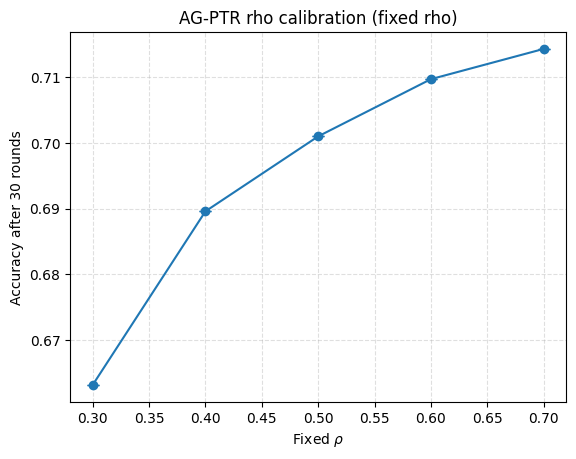

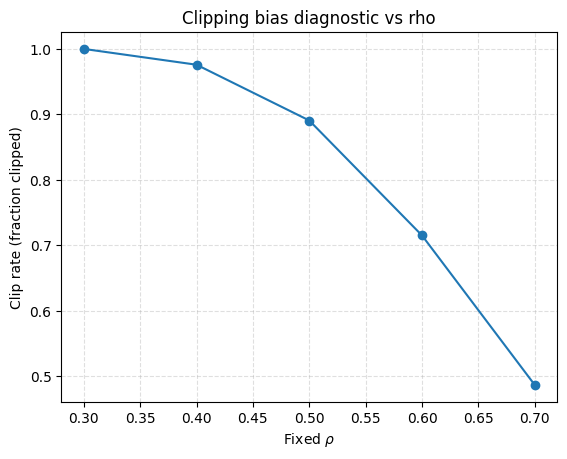

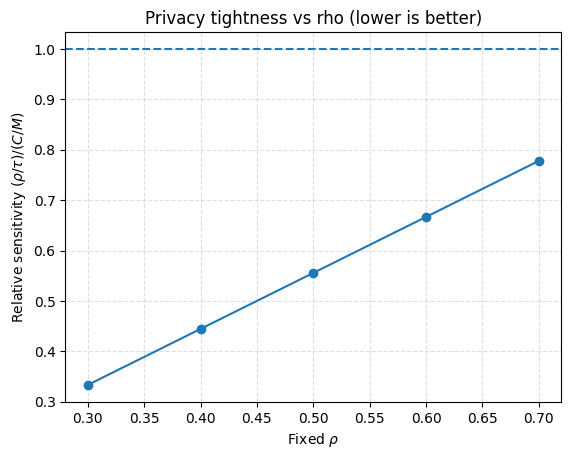

In [12]:
#tuning Cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calibration setup (cheap)
EPS_CAL = 4
SEEDS_CAL = [1]          # start with 1 seed; if time allows, use [1,2]
ROUNDS_CAL = 30
LOCAL_EPOCHS_CAL = 2

NUM_CLIENTS = 6000
M = 100
DELTA = 1e-5

CLIP_C = 1.0
TAU = 90
SEL_FACTOR = 4.0
R = 8

RHO_GRID = [0.3, 0.4, 0.5, 0.6, 0.7]

rows = []
q = M / NUM_CLIENTS

for rho in RHO_GRID:
    accs, ars, contribs, clips = [], [], [], []
    for sd in SEEDS_CAL:
        acc_ag, _, _, ar, avg_contrib, clip_rate = train_ag_ptr(
            sd, EPS_CAL, delta=DELTA,
            num_clients=NUM_CLIENTS, clients_per_round=M,
            rounds=ROUNDS_CAL, local_epochs=LOCAL_EPOCHS_CAL, batch_size=10,
            lr0=0.125, lr_decay=0.99, momentum=0.5,
            R=R, rho=rho, tau=TAU, sel_factor=SEL_FACTOR,
            warmup_rounds=0, rho_warmup=None,   # FIXED rho (no schedule)
            log_every=0
        )
        accs.append(acc_ag)
        ars.append(ar)
        contribs.append(avg_contrib)
        clips.append(clip_rate)

    noise_ratio = (rho/TAU) / (CLIP_C/M)   # (rho/tau) / (C/M)
    rows.append({
        "rho": rho,
        "acc_mean": float(np.mean(accs)),
        "acc_std": float(np.std(accs)),
        "accept_mean": float(np.mean(ars)),
        "avg_contrib_mean": float(np.mean(contribs)),
        "clip_rate_mean": float(np.mean(clips)),
        "rel_sens_ratio_(rho/tau)/(C/M)": float(noise_ratio),
    })

df_rho = pd.DataFrame(rows)
print(df_rho)

# Plot: accuracy vs rho
plt.figure()
plt.errorbar(df_rho["rho"], df_rho["acc_mean"], yerr=df_rho["acc_std"], marker="o", capsize=4)
plt.xlabel(r"Fixed $\rho$")
plt.ylabel(f"Accuracy after {ROUNDS_CAL} rounds")
plt.title("AG-PTR rho calibration (fixed rho)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# Plot: clip rate vs rho
plt.figure()
plt.plot(df_rho["rho"], df_rho["clip_rate_mean"], marker="o")
plt.xlabel(r"Fixed $\rho$")
plt.ylabel("Clip rate (fraction clipped)")
plt.title("Clipping bias diagnostic vs rho")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# Optional: ratio vs rho
plt.figure()
plt.plot(df_rho["rho"], df_rho["rel_sens_ratio_(rho/tau)/(C/M)"], marker="o")
plt.axhline(1.0, linestyle="--")
plt.xlabel(r"Fixed $\rho$")
plt.ylabel(r"Relative sensitivity $(\rho/\tau)/(C/M)$")
plt.title("Privacy tightness vs rho (lower is better)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


In [12]:
#test cell

# Preflight: quick sanity check (few rounds, one seed, one eps)
EPS = 4
SEED = 1

NUM_CLIENTS = 6000
M = 100
ROUNDS_SMOKE = 15          # small
LOCAL_EPOCHS_SMOKE = 2     # small
DELTA = 1e-5

CLIP_C = 1.0
RHO = 0.3
TAU = 90                  # try higher tau in benign case to tighten rho/tau
SEL_FACTOR = 4.0

q = M / NUM_CLIENTS
print("----- sensitivity / noise sanity -----")
# add/remove style sensitivity scales
print(f"FedAvg sensitivity scale ~ C/M = {CLIP_C/M:.6f}")
print(f"AG-PTR sensitivity scale ~ rho/tau = {RHO/TAU:.6f}")
print("Condition to be tighter:", (RHO/TAU) < (CLIP_C/M))

report_noise_scales(EPS, q, ROUNDS_SMOKE, DELTA, C=CLIP_C, M=M, rho=RHO, tau=TAU, sel_factor=SEL_FACTOR)

print("\n----- short training smoke test -----")
acc_fa, _, _ = train_dp_fedavg(
    SEED, EPS, delta=DELTA,
    num_clients=NUM_CLIENTS, clients_per_round=M,
    rounds=ROUNDS_SMOKE, local_epochs=LOCAL_EPOCHS_SMOKE, batch_size=10,
    lr0=0.125, lr_decay=0.99, momentum=0.5,
    clip_C=CLIP_C
)

acc_ag, _, _, ar, avg_contrib, clip_rate = train_ag_ptr(
    SEED, EPS, delta=DELTA,
    num_clients=NUM_CLIENTS, clients_per_round=M,
    rounds=ROUNDS_SMOKE, local_epochs=LOCAL_EPOCHS_SMOKE, batch_size=10,
    lr0=0.125, lr_decay=0.99, momentum=0.5,
    R=8, rho=RHO, tau=TAU, sel_factor=SEL_FACTOR,
    warmup_rounds=10, rho_warmup=0.8,  # helps early
    log_every=5
)

print(f"\nSmoke acc after {ROUNDS_SMOKE} rounds:")
print("  DP-FedAvg:", acc_fa)
print("  AG-PTR  :", acc_ag)
print(f"  AG-PTR accept={ar:.3f}, avg_contrib={avg_contrib:.1f}, clip_rate={clip_rate:.3f}")


----- sensitivity / noise sanity -----
FedAvg sensitivity scale ~ C/M = 0.010000
AG-PTR sensitivity scale ~ rho/tau = 0.003333
Condition to be tighter: True


/usr/local/lib/python3.12/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Target eps_total = 4
q=0.0167, rounds=15, delta=1e-05
[DP-FedAvg] nm=0.6316  -> noise_std_on_mean = 0.0063157 (C/M)
[AG-PTR]   nm_sel=2.5266
[AG-PTR]   nm_rel=0.6316 -> noise_std_on_release ≈ 0.0021055 (rho/tau)
[AG-PTR] achieved eps ≈ 4.000 (target 4)
Noise ratio (AG-PTR / FedAvg) = 0.333

----- short training smoke test -----
[DP-FedAvg] target eps=4 -> nm=0.6316, achieved eps≈4.000, mean-noise-std≈0.0063157


DP-FedAvg eps=4: 100%|██████████| 15/15 [00:08<00:00,  1.67it/s]


[AG-PTR] eps=4 -> nm_rel=0.6316, nm_sel=2.5266, achieved eps≈4.000


AG-PTR eps=4:  33%|███▎      | 5/15 [00:03<00:06,  1.43it/s]

  [t=5] accept=1.000, avg_contrib=100.0, clip_rate=0.168


AG-PTR eps=4:  67%|██████▋   | 10/15 [00:06<00:03,  1.45it/s]

  [t=10] accept=1.000, avg_contrib=100.0, clip_rate=0.349


AG-PTR eps=4: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

  [t=15] accept=1.000, avg_contrib=100.0, clip_rate=0.566



Smoke acc after 15 rounds:
  DP-FedAvg: 0.6658
  AG-PTR  : 0.6513
  AG-PTR accept=1.000, avg_contrib=100.0, clip_rate=0.566


In [12]:
# Cell 12 — Run the Experiment 1 core sweep (DP‑FedAvg + AG‑PTR) and save core CSV

EPS_GRID = [1, 2, 4]
SEEDS = [1, 2, 3]

DELTA = 1e-5
ROUNDS = 180
NUM_CLIENTS = 6000
CLIENTS_PER_ROUND = 100
LOCAL_EPOCHS = 10
BATCH_SIZE = 10
LR0 = 0.125
LR_DECAY = 0.99
MOMENTUM = 0.5

CLIP_C = 1.0
RHO = 0.85
TAU = 90
SEL_FACTOR = 4.0
R_ANCHORS = 8

# Sanity: print the REAL noise-on-release comparison
q = CLIENTS_PER_ROUND / NUM_CLIENTS
for eps in EPS_GRID:
    report_noise_scales(eps, q, ROUNDS, DELTA, C=CLIP_C, M=CLIENTS_PER_ROUND, rho=RHO, tau=TAU, sel_factor=SEL_FACTOR)
    print("")

rows = []

for eps in EPS_GRID:
    # DP-FedAvg
    accs = []
    for sd in SEEDS:
        acc, achieved_eps, sigma = train_dp_fedavg(
            sd, eps, delta=DELTA,
            num_clients=NUM_CLIENTS, clients_per_round=CLIENTS_PER_ROUND,
            rounds=ROUNDS, local_epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE,
            lr0=LR0, lr_decay=LR_DECAY, momentum=MOMENTUM,
            clip_C=CLIP_C
        )
        accs.append(acc)
    rows.append({
        "method": "DP-FedAvg",
        "eps_target": eps,
        "acc_mean": float(np.mean(accs)),
        "acc_std": float(np.std(accs)),
    })

    # AG-PTR
    acc, achieved_eps, (sig_sel, sig_rel), ar, avg_contrib, clip_rate = train_ag_ptr(
    sd, eps, delta=DELTA,
    num_clients=NUM_CLIENTS, clients_per_round=CLIENTS_PER_ROUND,
    rounds=ROUNDS, local_epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE,
    lr0=LR0, lr_decay=LR_DECAY, momentum=MOMENTUM,
    R=R_ANCHORS, rho=RHO, tau=TAU, sel_factor=SEL_FACTOR,
    warmup_rounds=0, rho_warmup=None,
    include_zero_anchor=False,   # or True if zero is not dominating
    debug_anchors=False,
    log_every=0
    )



    rows.append({
        "method": "AG-PTR",
        "eps_target": eps,
        "acc_mean": float(np.mean(accs)),  # (keep your mean/std logic the same if you do multiple seeds)
        "acc_std": float(np.std(accs)),
        "accept_rate_mean": float(np.mean(acc_rates)),
        "avg_contrib_mean": float(np.mean(avg_contribs)),
        "clip_rate_mean": float(np.mean(clip_rates)),
    })


df_core = pd.DataFrame(rows)
print(df_core)

os.makedirs("results", exist_ok=True)
core_path = "results/exp1_core.csv"
df_core.to_csv(core_path, index=False)
print("Saved:", core_path)



/usr/local/lib/python3.12/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Target eps_total = 1
q=0.0167, rounds=180, delta=1e-05
[DP-FedAvg] nm=1.3142  -> noise_std_on_mean = 0.0131425 (C/M)
[AG-PTR]   nm_sel=5.2895
[AG-PTR]   nm_rel=1.3224 -> noise_std_on_release ≈ 0.00661182 (rho/tau)
[AG-PTR] achieved eps ≈ 1.000 (target 1)
Noise ratio (AG-PTR / FedAvg) = 0.503

Target eps_total = 2
q=0.0167, rounds=180, delta=1e-05
[DP-FedAvg] nm=0.9713  -> noise_std_on_mean = 0.00971334 (C/M)
[AG-PTR]   nm_sel=3.8944
[AG-PTR]   nm_rel=0.9736 -> noise_std_on_release ≈ 0.00486804 (rho/tau)
[AG-PTR] achieved eps ≈ 2.000 (target 2)
Noise ratio (AG-PTR / FedAvg) = 0.501

Target eps_total = 4
q=0.0167, rounds=180, delta=1e-05
[DP-FedAvg] nm=0.7472  -> noise_std_on_mean = 0.00747219 (C/M)
[AG-PTR]   nm_sel=2.9922
[AG-PTR]   nm_rel=0.7481 -> noise_std_on_release ≈ 0.00374029 (rho/tau)
[AG-PTR] achieved eps ≈ 4.000 (target 4)
Noise ratio (AG-PTR / FedAvg) = 0.501

[DP-FedAvg] target eps=1 -> nm=1.3142, achieved eps≈1.000, mean-noise-std≈0.0131425


DP-FedAvg eps=1: 100%|██████████| 180/180 [06:45<00:00,  2.25s/it]


[DP-FedAvg] target eps=1 -> nm=1.3142, achieved eps≈1.000, mean-noise-std≈0.0131425


DP-FedAvg eps=1: 100%|██████████| 180/180 [06:52<00:00,  2.29s/it]


[DP-FedAvg] target eps=1 -> nm=1.3142, achieved eps≈1.000, mean-noise-std≈0.0131425


DP-FedAvg eps=1: 100%|██████████| 180/180 [06:58<00:00,  2.33s/it]


[AG-PTR] target eps=1 -> sigma_rel=1.3224, sigma_sel=5.2895, achieved eps≈1.000


AG-PTR eps=1: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


[AG-PTR] target eps=1 -> sigma_rel=1.3224, sigma_sel=5.2895, achieved eps≈1.000


AG-PTR eps=1: 100%|██████████| 180/180 [06:46<00:00,  2.26s/it]


[AG-PTR] target eps=1 -> sigma_rel=1.3224, sigma_sel=5.2895, achieved eps≈1.000


AG-PTR eps=1: 100%|██████████| 180/180 [06:44<00:00,  2.25s/it]


[DP-FedAvg] target eps=2 -> nm=0.9713, achieved eps≈2.000, mean-noise-std≈0.00971334


DP-FedAvg eps=2: 100%|██████████| 180/180 [06:54<00:00,  2.30s/it]


[DP-FedAvg] target eps=2 -> nm=0.9713, achieved eps≈2.000, mean-noise-std≈0.00971334


DP-FedAvg eps=2: 100%|██████████| 180/180 [06:56<00:00,  2.31s/it]


[DP-FedAvg] target eps=2 -> nm=0.9713, achieved eps≈2.000, mean-noise-std≈0.00971334


DP-FedAvg eps=2: 100%|██████████| 180/180 [07:04<00:00,  2.36s/it]


[AG-PTR] target eps=2 -> sigma_rel=0.9736, sigma_sel=3.8944, achieved eps≈2.000


AG-PTR eps=2: 100%|██████████| 180/180 [06:33<00:00,  2.19s/it]


[AG-PTR] target eps=2 -> sigma_rel=0.9736, sigma_sel=3.8944, achieved eps≈2.000


AG-PTR eps=2: 100%|██████████| 180/180 [06:24<00:00,  2.14s/it]


[AG-PTR] target eps=2 -> sigma_rel=0.9736, sigma_sel=3.8944, achieved eps≈2.000


AG-PTR eps=2: 100%|██████████| 180/180 [06:26<00:00,  2.15s/it]


[DP-FedAvg] target eps=4 -> nm=0.7472, achieved eps≈4.000, mean-noise-std≈0.00747219


DP-FedAvg eps=4: 100%|██████████| 180/180 [06:32<00:00,  2.18s/it]


[DP-FedAvg] target eps=4 -> nm=0.7472, achieved eps≈4.000, mean-noise-std≈0.00747219


DP-FedAvg eps=4: 100%|██████████| 180/180 [06:37<00:00,  2.21s/it]


[DP-FedAvg] target eps=4 -> nm=0.7472, achieved eps≈4.000, mean-noise-std≈0.00747219


DP-FedAvg eps=4: 100%|██████████| 180/180 [06:33<00:00,  2.18s/it]


[AG-PTR] target eps=4 -> sigma_rel=0.7481, sigma_sel=2.9922, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 180/180 [06:31<00:00,  2.18s/it]


[AG-PTR] target eps=4 -> sigma_rel=0.7481, sigma_sel=2.9922, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 180/180 [06:30<00:00,  2.17s/it]


[AG-PTR] target eps=4 -> sigma_rel=0.7481, sigma_sel=2.9922, achieved eps≈4.000


AG-PTR eps=4: 100%|██████████| 180/180 [06:40<00:00,  2.23s/it]


      method  eps_target  acc_mean   acc_std  accept_rate_mean
0  DP-FedAvg           1  0.729100  0.004445               NaN
1     AG-PTR           1  0.543800  0.098825          0.883333
2  DP-FedAvg           2  0.777500  0.002393               NaN
3     AG-PTR           2  0.649333  0.015137          0.848148
4  DP-FedAvg           4  0.805500  0.002963               NaN
5     AG-PTR           4  0.676267  0.005681          0.809259
Saved: results/exp1_core.csv


Saved: results/exp1_privacy_utility.csv


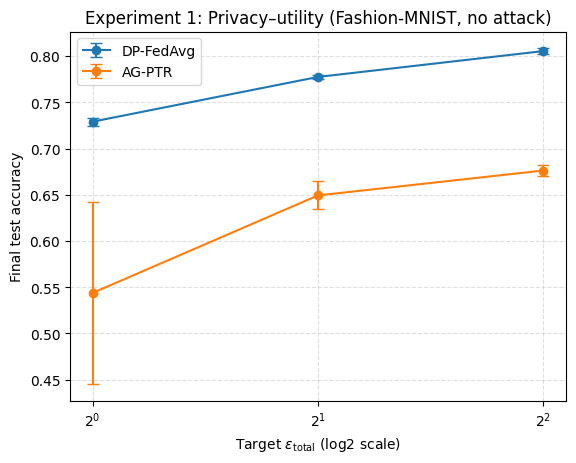

Saved: results/exp1_privacy_utility.png


In [15]:
# Cell 13 — Save CSV + plot accuracy vs epsilon
import os
import matplotlib.pyplot as plt

# Save CSV
os.makedirs("results", exist_ok=True)
csv_path = "results/exp1_privacy_utility.csv"
df_core.to_csv(csv_path, index=False)
print("Saved:", csv_path)

# Plot
plt.figure()
for method in df_core["method"].unique():
    sub = df_core[df_core["method"] == method].sort_values("eps_target")
    plt.errorbar(
        sub["eps_target"],
        sub["acc_mean"],
        yerr=sub["acc_std"],
        marker="o",
        capsize=4,
        label=method
    )

plt.xscale("log", base=2)
plt.xlabel(r"Target $\varepsilon_{\mathrm{total}}$ (log2 scale)")
plt.ylabel("Final test accuracy")
plt.title("Experiment 1: Privacy–utility (Fashion-MNIST, no attack)")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()

fig_path = "results/exp1_privacy_utility.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", fig_path)


In [16]:
# cell 14 - PDPBRFL. (official repo) — “no attack” run
# --- Clone + install ---
%cd /content
!rm -rf Practical-Differentially-Private-and-Byzantine-resilient-Federated
!git clone https://github.com/zihangxiang/Practical-Differentially-Private-and-Byzantine-resilient-Federated
%cd Practical-Differentially-Private-and-Byzantine-resilient-Federated
!pip -q install -r requirements.txt

# --- Runner + parser ---
import re, subprocess, pandas as pd, numpy as np, os

def run_cmd_capture(cmd, log_path):
    p = subprocess.run(cmd, text=True, capture_output=True)
    out = p.stdout + "\n" + p.stderr
    with open(log_path, "w") as f:
        f.write(out)
    return out

def parse_test_acc(text):
    t = text.lower()
    pats = [
        r"test[^0-9a-z]*acc(?:uracy)?\s*[:=]\s*([0-9]*\.?[0-9]+)",
        r"final[^0-9a-z]*acc(?:uracy)?\s*[:=]\s*([0-9]*\.?[0-9]+)",
        r"best[^0-9a-z]*test[^0-9a-z]*acc(?:uracy)?\s*[:=]\s*([0-9]*\.?[0-9]+)",
    ]
    for pat in pats:
        ms = re.findall(pat, t)
        if ms:
            return float(ms[-1])
    return None

EPS_GRID = [1, 2, 4]
SEEDS = [1, 2, 3]

os.makedirs("/content/results", exist_ok=True)
rows = []

for eps in EPS_GRID:
    accs = []
    for sd in SEEDS:
        log_path = f"/content/results/xiang_eps{eps}_seed{sd}.log"
        cmd = [
            "python", "main.py",
            "--dataset", "fashion",
            "--att_key", "nobyz",
            "--epsilon", str(eps),
            "--DP_mode", "centralDP",
            "--seed", str(sd),
            "--mal_worker_portion", "0",
            "--anti_byz", "1",
            "--non_iid", "0",
            "--start_att", "0.0",
            "--base_lr", "0.2"
        ]
        out = run_cmd_capture(cmd, log_path)
        acc = parse_test_acc(out)
        if acc is None:
            print(f"[Xiang] Could not parse accuracy from {log_path}. Showing last 40 lines:")
            print("\n".join(out.splitlines()[-40:]))
            raise RuntimeError("Parsing failed; adjust parse_test_acc() patterns to match their output.")
        accs.append(acc)

    rows.append({
        "method": "Xiang-et-al",
        "eps_target": eps,
        "acc_mean": float(np.mean(accs)),
        "acc_std": float(np.std(accs)),
    })

df_x = pd.DataFrame(rows)
df_x.to_csv("/content/results/exp1_xiang.csv", index=False)
print(df_x)
print("Saved: /content/results/exp1_xiang.csv")


/content
Cloning into 'Practical-Differentially-Private-and-Byzantine-resilient-Federated'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 48 (delta 2), reused 4 (delta 2), pack-reused 37 (from 1)
Receiving objects: 100% (48/48), 6.47 MiB | 8.87 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/Practical-Differentially-Private-and-Byzantine-resilient-Federated
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 35.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Ignored the following yanked versions: 2.4.0
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.

RuntimeError: Parsing failed; adjust parse_test_acc() patterns to match their output.

In [17]:
# Cell 15 Because the DP‑BREM repo doesn’t document exact CLI flags in the README,
#this cell first prints args/help, then gives you a runnable scaffold + the same “parse into CSV” logic:
%cd /content
!rm -rf DP-BREM
!git clone https://github.com/xiaolangu/DP-BREM.git
%cd DP-BREM

# Inspect available CLI args (copy the right flags into the command below)
!python main.py --help || true
!sed -n '1,220p' args.py


/content
Cloning into 'DP-BREM'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 28 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 22.36 KiB | 11.18 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/DP-BREM
2026-02-13 10:05:35.051276: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-13 10:05:35.063222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770977135.078265   45209 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDN

In [18]:
#cell 16  once you see the real flags (dataset name, epsilon flag, byzantine ratio flag, etc.).
# After  edit the cmd = [...] list to match DP‑BREM’s argparse, the rest will auto-sweep eps/seeds and write results/exp1_dpbrem.csv
import re, subprocess, pandas as pd, numpy as np, os

def run_cmd_capture(cmd, log_path):
    p = subprocess.run(cmd, text=True, capture_output=True)
    out = p.stdout + "\n" + p.stderr
    with open(log_path, "w") as f:
        f.write(out)
    return out

def parse_test_acc(text):
    t = text.lower()
    pats = [
        r"test[^0-9a-z]*acc(?:uracy)?\s*[:=]\s*([0-9]*\.?[0-9]+)",
        r"final[^0-9a-z]*acc(?:uracy)?\s*[:=]\s*([0-9]*\.?[0-9]+)",
        r"avg[^0-9a-z]*acc(?:uracy)?\s*[:=]\s*([0-9]*\.?[0-9]+)",
    ]
    for pat in pats:
        ms = re.findall(pat, t)
        if ms:
            return float(ms[-1])
    return None

EPS_GRID = [1, 2, 4]
SEEDS = [1, 2, 3]

os.makedirs("/content/results", exist_ok=True)
rows = []

for eps in EPS_GRID:
    accs = []
    for sd in SEEDS:
        log_path = f"/content/results/dpbrem_eps{eps}_seed{sd}.log"

        # TODO: EDIT THESE FLAGS to match DP-BREM's args.py
        cmd = [
            "python", "main.py",
            "--dataset", "fashionmnist",     # <-- change if needed (e.g., fmnist)
            "--epsilon", str(eps),           # <-- change if needed (e.g., --eps)
            "--seed", str(sd),
            "--byz_frac", "0.0",             # <-- change flag name; set 0 attack
            "--attack", "none",              # <-- change if needed
        ]

        out = run_cmd_capture(cmd, log_path)
        acc = parse_test_acc(out)
        if acc is None:
            print(f"[DP-BREM] Could not parse accuracy from {log_path}. Showing last 60 lines:")
            print("\n".join(out.splitlines()[-60:]))
            raise RuntimeError("Parsing failed; adjust cmd flags + parse_test_acc() patterns.")

        accs.append(acc)

    rows.append({
        "method": "DP-BREM",
        "eps_target": eps,
        "acc_mean": float(np.mean(accs)),
        "acc_std": float(np.std(accs)),
    })

df_b = pd.DataFrame(rows)
df_b.to_csv("/content/results/exp1_dpbrem.csv", index=False)
print(df_b)
print("Saved: /content/results/exp1_dpbrem.csv")


[DP-BREM] Could not parse accuracy from /content/results/dpbrem_eps1_seed1.log. Showing last 60 lines:

2026-02-13 10:06:27.883968: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-13 10:06:27.896555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770977187.911261   45539 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770977187.915910   45539 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770977187.928789   45539 c

RuntimeError: Parsing failed; adjust cmd flags + parse_test_acc() patterns.

In [ ]:
#cell 17 merge
# Cell 13 — Merge external baseline results (Xiang, DP-BREM/+) + plot

# 1) Fill these after you run the official repos.
# Put mean/std over the same 3 seeds for eps=1,2,4.
external_rows = [
    # {"method": "Xiang-et-al", "eps_target": 1, "acc_mean": 0.0, "acc_std": 0.0},
    # {"method": "Xiang-et-al", "eps_target": 2, "acc_mean": 0.0, "acc_std": 0.0},
    # {"method": "Xiang-et-al", "eps_target": 4, "acc_mean": 0.0, "acc_std": 0.0},

    # {"method": "DP-BREM",   "eps_target": 1, "acc_mean": 0.0, "acc_std": 0.0},
    # {"method": "DP-BREM",   "eps_target": 2, "acc_mean": 0.0, "acc_std": 0.0},
    # {"method": "DP-BREM",   "eps_target": 4, "acc_mean": 0.0, "acc_std": 0.0},

    # If you also run DP-BREM+ separately, add it as its own method label:
    # {"method": "DP-BREM+",  "eps_target": 1, "acc_mean": 0.0, "acc_std": 0.0},
]

df_ext = pd.DataFrame(external_rows) if len(external_rows) else pd.DataFrame(columns=df_core.columns)

# Combine
df_all = pd.concat([df_core, df_ext], ignore_index=True, sort=False)

all_path = "results/exp1_all.csv"
df_all.to_csv(all_path, index=False)
print("Saved:", all_path)
print(df_all)

# Plot
plt.figure()
for method in df_all["method"].unique():
    sub = df_all[df_all["method"] == method].sort_values("eps_target")
    if len(sub) == 0:
        continue
    yerr = sub["acc_std"] if "acc_std" in sub.columns else None
    plt.errorbar(sub["eps_target"], sub["acc_mean"], yerr=yerr, marker="o", capsize=4, label=method)

plt.xscale("log", base=2)
plt.xlabel(r"Target $\varepsilon_{\mathrm{total}}$ (log2 scale)")
plt.ylabel("Final test accuracy")
plt.title("Experiment 1: Privacy–utility (Fashion-MNIST, no attack)")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()

fig_path = "results/exp1_privacy_utility.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", fig_path)

